# Выбор локации для скважины

Добывающей компании нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [2]:
#ячейка для функций
def revenue(pred, y_valid, k, income, cost):
    _ = pred.sort_values(ascending=False)[:k]
    __ = y_valid[_.index]
    return __.sum() * income - cost

def rev_risk(pred, y_valid):
    revs = []
    for i in range(1000):
        product_subsample = pred.sample(n=N, replace=True, random_state=RANDOM_STATE) # replace=False,
                                                                    # так как нельзя исследовать одну скважину дважды
        rev = revenue(product_subsample, y_valid[product_subsample.index], K, INCOME, COST)
        revs.append(rev)

    revs = pd.Series(revs)
    lower = revs.quantile(0.025)
    higher = revs.quantile(0.975)

    display('Средняя прибыль в регионе в млн рублей:', revs.mean())
    display('95% доверительный интервал:', (lower, higher))
    display('Процент возможных убытков в регионе:', (revs < 0).mean() * 100)
    
def mod(df):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)
    # данные хорошие: их не надо кодить, применять скалер и заполнять пропуски, только обучить модель
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    display('Средние предсказанные запасы сырья в регионе:', pred.mean())
    display('RMSE модели:', math.sqrt(mse(y_valid, pred)))
    pred = pd.Series(pred, name='pred')
    y_valid = y_valid.reset_index(drop=True) # сбросил индекс, так как в конечном итоге важно выбрать регион, а не
                                             # конкретные скважины
    return pred, y_valid

def graf(df):
    plt.rcParams['figure.figsize'] = [15, 4]
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = df, x = df['product'], kde=True, bins=10)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = df, x = df['product'], palette='pastel')
    plt.show()

In [3]:
#ячейка для объявления констант
RANDOM_STATE = np.random.RandomState(12345)
TEST_SIZE = 0.25

COST = 10 * 10**3 # затраты в млн рублей
INCOME = 0.45     # доход с единицы продукты в млн рублей
N = 500           # кол-во скважин для исследования
K = 200           # кол-во скважин для разработки

In [4]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
display(df1.head())
df1.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df2 = pd.read_csv('/datasets/geo_data_1.csv')
display(df2.head())
df2.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df3 = pd.read_csv('/datasets/geo_data_2.csv')
display(df3.head())
df3.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Все датасеты загружены верно. В них нет пропусков, типы данных в колонках тоже верные. Надо проверить на дубликаты. В этих датасетах могут быть только явные дубликаты. Неявных быть не может, так как в _id_ различаются заглавные и строчные буквы.

In [7]:
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()
df3 = df3.drop_duplicates()
df1.info()
print()
df2.info()
print()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

Полных дубликатов нет. Но нужно еще посмотреть дубликаты по _id_.

In [8]:
df1[df1['id'].isin(df1[df1.duplicated(subset=['id'])]['id'])]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


Думаю, что лучше будет удалить все строки с дублированными _id_. Потому что в данных есть различия в колонке _product_, а эта информация влияет на принятие решения бурить или не бурить.

In [9]:
df1 = df1.drop(df1[df1['id'].isin(df1[df1.duplicated(subset=['id'])]['id'])].index)
df1[df1['id'].isin(df1[df1.duplicated(subset=['id'])]['id'])]['id'].count()

0

In [10]:
df2 = df2.drop(df2[df2['id'].isin(df2[df2.duplicated(subset=['id'])]['id'])].index)
df3 = df3.drop(df3[df3['id'].isin(df3[df3.duplicated(subset=['id'])]['id'])].index)

In [11]:
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df3 = df3.reset_index(drop=True)

In [12]:
df1.info()
print()
df2.info()
print()
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99980 entries, 0 to 99979
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  


Во всех датасетах удалил строки с дублированными _id_. Из первого датасета ушло 20 строк, из второго и из третьего &mdash; по 8. На этом заканчиваю предобработку.

## Обучение и проверка модели

### Первый регион

In [13]:
pred1, y_valid_1 = mod(df1)

'Средние предсказанные запасы сырья в регионе:'

92.42384109947359

'RMSE модели:'

37.716904960382735

RMSE высокое. Предполагаю, что есть выбросы в целевом признаке.

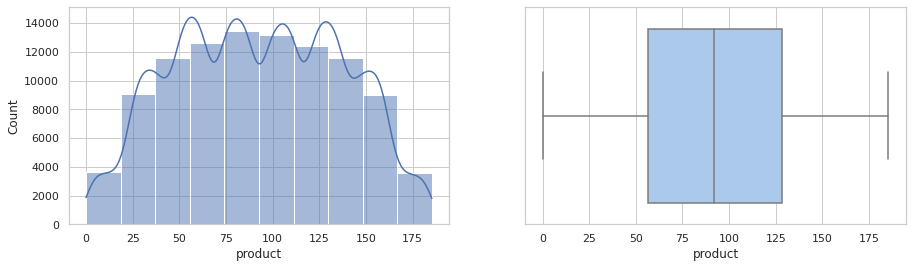

In [14]:
graf(df1)

Но на боксплоте выбросов не видно.

### Второй регион

In [15]:
pred2, y_valid_2 = mod(df2)

'Средние предсказанные запасы сырья в регионе:'

68.79207009357762

'RMSE модели:'

0.8899728648236697

Во втором регионе RMSE меньше 1, что говорит о хорошей работе модели. Но среднее значение запасов ниже, чем в первом регионе.

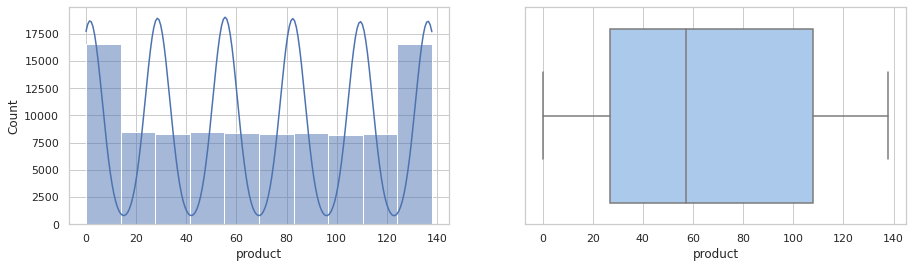

In [16]:
graf(df2)

А здесь медианное значение примерно на 10 пунктов ниже предсказанного среднего.

### Третий регион

In [17]:
pred3, y_valid_3 = mod(df3)

'Средние предсказанные запасы сырья в регионе:'

95.25725596652306

'RMSE модели:'

40.077773873280115

Средние запасы сырья выше, чем во втором регионе, ошибка тоже выше. Характеристики этого региона похожи на характеристики первого.

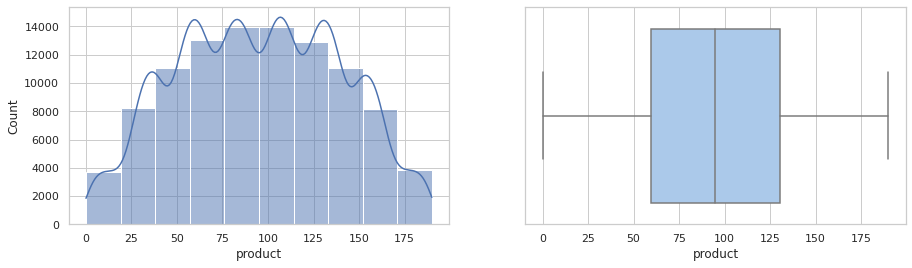

In [18]:
graf(df3)

## Подготовка к расчёту прибыли

Функция расчета прибыли, а также все константы объявлены перед загрузкой и подготовкой данных.

In [19]:
# k*income*x >= cost, где k -- кол-во исследуемых скважин, income -- доход с единицы продукции, x -- кол-во единиц
# продукции в каждой скважине, cost -- бюджет на разработку скважин в регионе
# x = cost / (k*income)
x = COST / (K * INCOME)
x

111.11111111111111

Минимальное количество единиц сырья в скважине должно быть не меньше 111,12. Средние значения по каждому региону ниже, но в этих регионах около 100000 возможных скважин, из которых примерно по 25000 в валидационной выборке. Думаю, что найдутся с необходимым количеством сырья.

## Расчёт прибыли и рисков 

In [20]:
rev_risk(pred1, y_valid_1)

'Средняя прибыль в регионе в млн рублей:'

646.4555985929501

'95% доверительный интервал:'

(70.48844164854228, 1328.2874564228414)

'Процент возможных убытков в регионе:'

1.5

In [21]:
rev_risk(pred2, y_valid_2)

'Средняя прибыль в регионе в млн рублей:'

652.661888364542

'95% доверительный интервал:'

(159.47972231968052, 1150.579638706255)

'Процент возможных убытков в регионе:'

0.5

In [22]:
rev_risk(pred3, y_valid_3)

'Средняя прибыль в регионе в млн рублей:'

557.7968095482773

'95% доверительный интервал:'

(-53.41531086409776, 1201.8846445387958)

'Процент возможных убытков в регионе:'

3.4000000000000004

## Вывод

По всем параметрам лучший регион &mdash; второй. Процент возможных убытков меньше 2.5%, только этот регион удовлетворяет требованиям заказчика. Более того, в этом регионе прибыль самая высокая.